In [80]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Function to fetch historical data using yfinance
def get_historical_data_yf(ticker, start_date, end_date):
    # Fetch historical data
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    data.reset_index(inplace=True)
    return data

# Function to calculate MACD, Bollinger Bands, and RSI
def calculate_indicators(df):
    # Calculate MACD
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Calculate Bollinger Bands
    df['20_MA'] = df['Close'].rolling(window=20).mean()
    df['20_STD'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_MA'] + (df['20_STD'] * 2)
    df['Lower_Band'] = df['20_MA'] - (df['20_STD'] * 2)

    # Calculate RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    return df

# Function to generate trading signals with MACD, Bollinger Bands, and RSI
def generate_signals(df):
    signals = []
    in_position = False
    entry_price = None
    
    # Loop through data to generate buy/sell signals
    for i in range(1, len(df)):
        row = df.iloc[i]
        prev_row = df.iloc[i-1]
        
        # MACD Strategy with RSI and Bollinger Bands
        if (prev_row['MACD'] < prev_row['Signal_Line'] and 
            row['MACD'] > row['Signal_Line'] and
            row['RSI'] < 30 and  # RSI below 30 (oversold condition)
            row['Close'] < row['Lower_Band']):
            if in_position:
                # Calculate Profit/Loss for the position we were in
                profit_loss = (row['Close'] - entry_price) / entry_price * 100
                signals.append({
                    'Date': row['Date'],
                    'Price': row['Close'],
                    'Signal': 'Sell',
                    'Entry_Price': entry_price,
                    'Exit_Price': row['Close'],
                    '%Profit_Loss': profit_loss
                })
                in_position = False
            else:
                entry_price = row['Close']
                in_position = True
                signals.append({
                    'Date': row['Date'],
                    'Price': row['Close'],
                    'Signal': 'Buy',
                    'Entry_Price': row['Close'],
                    'Exit_Price': None,
                    '%Profit_Loss': None
                })
        
        elif (prev_row['MACD'] > prev_row['Signal_Line'] and 
              row['MACD'] < row['Signal_Line'] and
              row['RSI'] > 70 and  # RSI above 70 (overbought condition)
              row['Close'] > row['Upper_Band']):
            if in_position:
                # Calculate Profit/Loss for the position we were in
                profit_loss = (row['Close'] - entry_price) / entry_price * 100
                signals.append({
                    'Date': row['Date'],
                    'Price': row['Close'],
                    'Signal': 'Sell',
                    'Entry_Price': entry_price,
                    'Exit_Price': row['Close'],
                    '%Profit_Loss': profit_loss
                })
                in_position = False
        
        # Additional RSI-based conditions (optional)
        # Buy when RSI is below 30 and price is below the lower Bollinger Band
        if row['RSI'] < 30 and row['Close'] < row['Lower_Band']:
            if in_position:
                profit_loss = (row['Close'] - entry_price) / entry_price * 100
                signals.append({
                    'Date': row['Date'],
                    'Price': row['Close'],
                    'Signal': 'Sell',
                    'Entry_Price': entry_price,
                    'Exit_Price': row['Close'],
                    '%Profit_Loss': profit_loss
                })
                in_position = False
            else:
                entry_price = row['Close']
                in_position = True
                signals.append({
                    'Date': row['Date'],
                    'Price': row['Close'],
                    'Signal': 'Buy',
                    'Entry_Price': row['Close'],
                    'Exit_Price': None,
                    '%Profit_Loss': None
                })

        # Sell when RSI is above 70 and price is above the upper Bollinger Band
        elif row['RSI'] > 70 and row['Close'] > row['Upper_Band']:
            if in_position:
                profit_loss = (row['Close'] - entry_price) / entry_price * 100
                signals.append({
                    'Date': row['Date'],
                    'Price': row['Close'],
                    'Signal': 'Sell',
                    'Entry_Price': entry_price,
                    'Exit_Price': row['Close'],
                    '%Profit_Loss': profit_loss
                })
                in_position = False

    # If still in position at the end, mark as unclosed
    if in_position:
        signals.append({
            'Date': df.iloc[-1]['Date'],
            'Price': df.iloc[-1]['Close'],
            'Signal': 'Unclosed',
            'Entry_Price': entry_price,
            'Exit_Price': None,
            '%Profit_Loss': None
        })
    
    return pd.DataFrame(signals)

# Fetch historical data for NIFTY50 from the last 10 years
start_date = '2013-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')

historical_data = get_historical_data_yf('^NSEI', start_date, end_date)

# Proceed if data is available
if not historical_data.empty:
    # Apply calculations
    historical_data = calculate_indicators(historical_data)

    # Generate trading signals
    trading_signals = generate_signals(historical_data)
    
    # Merge signals with historical_data
    merged_data = pd.merge(historical_data, trading_signals, left_on='Date', right_on='Date', how='left')

    # Save the combined DataFrame to a CSV file
    merged_data.to_csv('historical_data_with_signals.csv', index=False)
    print("Historical data with trading signals saved to 'historical_data_with_signals.csv'.")
else:
    print("No historical data available for NIFTY50.")


[*********************100%%**********************]  1 of 1 completed


Historical data with trading signals saved to 'historical_data_with_signals.csv'.


Win Rate (including zero trades): 55.03%
Loss Rate (excluding zero trades): 44.97%
Average Profit (Geometric Mean): 2.46%
Average Drawdown (Geometric Mean): 1.16%
Longest Win Streak: 7 records
Longest Loss Streak: 4 records


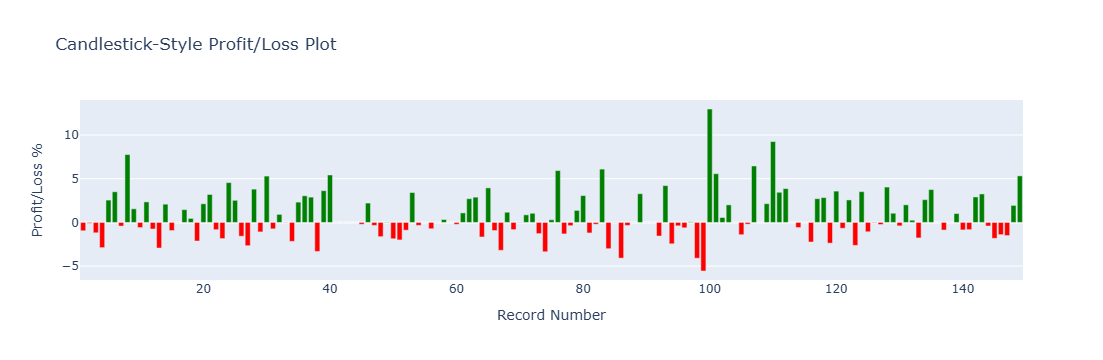

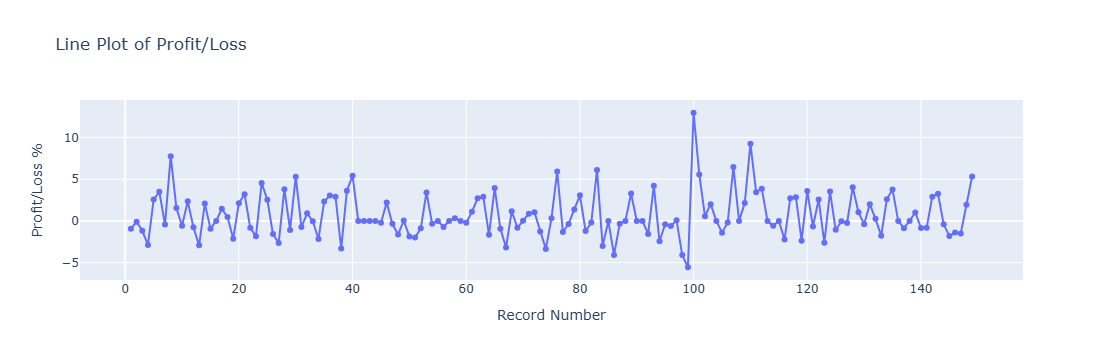

In [84]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Load the Excel file
file_path = r'C:\Users\surve\OneDrive\Desktop\Github Repository\Jupyter Notebook\Algo perf 2.xlsx'
df = pd.read_excel(file_path)

# Ensure the dataframe has the necessary columns
required_columns = [ 'Profit_Loss' ]
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"The Excel file must contain the following columns: {', '.join(required_columns)}")

# Create record numbers for the x-axis
df['Record_Number'] = range(1, len(df) + 1)

# Calculate metrics
total_trades = len(df)
winning_trades = df[df['Profit_Loss'] >= 0]  # Include zero trades as wins
losing_trades = df[df['Profit_Loss'] < 0]
zero_trades = df[df['Profit_Loss'] == 0]

# Win Rate (including zero trades as wins)
win_rate = len(winning_trades) / total_trades * 100

# Loss Rate (excluding zero trades)
loss_rate = len(losing_trades) / (total_trades ) * 100 if total_trades > len(zero_trades) else 0

# Average Profit (Geometric Mean of positive profits)
positive_profits = df['Profit_Loss'][df['Profit_Loss'] > 0]
avg_profit = np.exp(np.mean(np.log(positive_profits + 1))) - 1  # Adding 1 to avoid log(0)

# Average Drawdown (Geometric Mean of negative drawdowns)
negative_drawdowns = df['Profit_Loss'][df['Profit_Loss'] < 0]
avg_drawdown = np.exp(np.mean(np.log(-negative_drawdowns + 1))) - 1  # Adding 1 to avoid log(0)

# Calculate longest win streak and longest loss streak
def longest_streak(values, condition):
    streaks = []
    current_streak = 0
    for value in values:
        if condition(value):
            current_streak += 1
        else:
            if current_streak > 0:
                streaks.append(current_streak)
            current_streak = 0
    if current_streak > 0:
        streaks.append(current_streak)
    return max(streaks, default=0)

longest_win_streak = longest_streak(df['Profit_Loss'], lambda x: x >= 0)
longest_loss_streak = longest_streak(df['Profit_Loss'], lambda x: x < 0)

# Print the metrics
print(f"Win Rate (including zero trades): {win_rate:.2f}%")
print(f"Loss Rate (excluding zero trades): {loss_rate:.2f}%")
print(f"Average Profit (Geometric Mean): {avg_profit:.2f}%")
print(f"Average Drawdown (Geometric Mean): {avg_drawdown:.2f}%")
print(f"Longest Win Streak: {longest_win_streak} records")
print(f"Longest Loss Streak: {longest_loss_streak} records")

# Create the candlestick-style chart for profit/loss
colors = ['green' if profit > 0 else 'red' for profit in df['Profit_Loss']]

# Candlestick-style plot
fig_candle = go.Figure()

fig_candle.add_trace(go.Bar(
    x=df['Record_Number'],
    y=df['Profit_Loss'],
    marker_color=colors,
    name='Profit/Loss %'
))

fig_candle.update_layout(
    yaxis=dict(title='Profit/Loss %'),
    xaxis_title='Record Number',
    title='Candlestick-Style Profit/Loss Plot'
)

# Line plot
fig_line = go.Figure()

fig_line.add_trace(go.Scatter(
    x=df['Record_Number'],
    y=df['Profit_Loss'],
    mode='lines+markers',
    name='Profit/Loss %'
))

fig_line.update_layout(
    yaxis=dict(title='Profit/Loss %'),
    xaxis_title='Record Number',
    title='Line Plot of Profit/Loss'
)

# Show the plots
fig_candle.show()
fig_line.show()
